# Who deports more, Republicans or Democrats?

LIS MASc  
Everything Counts  
Assessment 2    
Student number: 24000114067

Access notebook online here: TODO

PDF generated using [nbconvert](https://nbconvert.readthedocs.io/en/latest/index.html)

## Introduction


Trump won the US election a few days ago. A surprising contingent of black and latino us citizens have voted for him. The idea being floated around regards the fact that while the biden presidency was better for the economy, people do not feel the economy.

I have been told the unlikely idea that the democrats deporting more than republicans - and this motivating latinos voting for trump even though that sounds contrary to their interests -. this would explain the latino votes for trump. it would mean that the voters care more about their personal situation than about the economy, and that they vote rationally instead of emotionally. assuming that trumps remarks about deporting legal immigrants and people eating cats and dogs wouldnt sit well with them, but
this would also point to trumps stuff as rhetoric that he doesnt actually do, but just says for the vibes.

## Data sources

Office of Homeland Security data (deportation): https://ohss.dhs.gov/topics/immigration/yearbook/2019/table39

US House of Representatives History data (parties): https://history.house.gov/Institution/Presidents-Coinciding/Party-Government/

## Feature explanation

**Removals** are the compulsory and confirmed movement of an inadmissible or deportable alien out of the United States based on an order of removal. An alien who is removed has administrative or criminal consequences placed on subsequent reentry owing to the fact of the removal.

**Returns** are the confirmed movement of an inadmissible or deportable alien out of the United States not based on an order of removal.

A **unified** government is when the President's party holds the majority in both chambers.

## Research question

Is there a higher rate of deportation of illegal immigrants in the US when the president is a Democrat?

## Hypothesis

H<sub>0</sub>: x̄<sub>D</sub> − x̄<sub>R</sub> = 0

H<sub>A</sub>: x̄<sub>D</sub> − x̄<sub>R</sub> ≠ 0

While the question is structured in a one-tailed way, if we need to ask this at all, it might be prudent to do a two-tailed test.

## Data cleaning

In [810]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.weightstats as st

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 0)

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (8, 4)
plt.rcParams["figure.dpi"] = 300

In [811]:
df = pd.read_csv("data/party.csv")
df.head()

,Congress,House Majority,Senate Majority,Presidency,Party Government
0,35th (1857–1859),Democrats,Democrats,Democrat (Buchanan),Unified
1,36th (1859–1861),Republicans,Democrats,Democrat (Buchanan),Divided
2,37th (1861–1863),Republicans,Republicans,Republican (Lincoln),Unified
3,38th (1863–1865),Republicans,Republicans,Republican (Lincoln),Unified
4,39th (1865–1867),Republicans,Republicans,Republican (Lincoln) / Democrat (A. Johnson),Unified / Divided


In [812]:
df.columns.to_list()



['Congress',
 'House Majority',
 'Senate Majority',
 'Presidency',
 'Party Government']

In [813]:
# rename columns
df = df.rename(
    columns={
        "Congress": "congress",
        "House Majority": "house_majority",
        "Senate Majority": "senate_majority",
        "Presidency": "presidency",
        "Party Government": "government",
    }
)

df.iloc[0]

congress               35th (1857–1859)
house_majority                Democrats
senate_majority               Democrats
presidency         Democrat (Buchanan) 
government                      Unified
Name: 0, dtype: object

### Missing values

In [814]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   congress         84 non-null     object
 1   house_majority   84 non-null     object
 2   senate_majority  84 non-null     object
 3   presidency       84 non-null     object
 4   government       84 non-null     object
dtypes: object(5)
memory usage: 32.2 KB


There are no missing values. However, when presidents resign or die, sometimes the vice-president is from the other party. Because of this complexity, we are dropping these cases. We keep the ones in which the two presidents are of the same party, as this shouldn't interfere with the analysis. This makes for very neat categories.

### Modifying features

#### Presidency 

We move the president's name to another variable so the `presidency` feature can become a category. 

In [815]:
df[['presidency', 'president']] = df['presidency'].str.extract(r'(.*)(\(.*\))')
df['president'] = df['president'].str.strip('()')
df.head()

,congress,house_majority,senate_majority,presidency,government,president
0,35th (1857–1859),Democrats,Democrats,Democrat,Unified,Buchanan
1,36th (1859–1861),Republicans,Democrats,Democrat,Divided,Buchanan
2,37th (1861–1863),Republicans,Republicans,Republican,Unified,Lincoln
3,38th (1863–1865),Republicans,Republicans,Republican,Unified,Lincoln
4,39th (1865–1867),Republicans,Republicans,Republican (Lincoln) / Democrat,Unified / Divided,A. Johnson


In [816]:
df['presidency'] = df['presidency'].astype("category")

#### Congress

In a similar but more involved way, we extract the years from the congress feature. The point is to have one row per year so that we can fit the two tables together. 

We assume that if the 35th congress spans 1857-1859 and the 36th spans 1859-1861, the end result should be:

| Year | Congress |
|------|----------|
| 1857 | 35th     |
| 1858 | 35th     |
| 1859 | 36th     |
| 1860 | 36th     |


In [817]:
df[['congress', 'year_start', 'year_end']] = df['congress'].str.extract(r'^(\d*)\w{2} \((.*)–(.*)\)')
df.iloc[0]

congress                  35
house_majority     Democrats
senate_majority    Democrats
presidency         Democrat 
government           Unified
president           Buchanan
year_start              1857
year_end                1859
Name: 0, dtype: object

In [818]:
new_rows = []
for k, v in df.iterrows():
    for i in range(int(v['year_start']), int(v['year_end'])):
        new_row = v.copy()
        new_row['year'] = i
        new_rows.append(new_row)
        
df = pd.DataFrame(new_rows)
df = df.drop(columns=['year_start', 'year_end'])

In [819]:
df.sort_values(by='year')

,congress,house_majority,senate_majority,presidency,government,president,year
0,35,Democrats,Democrats,Democrat,Unified,Buchanan,1857
0,35,Democrats,Democrats,Democrat,Unified,Buchanan,1858
1,36,Republicans,Democrats,Democrat,Divided,Buchanan,1859
1,36,Republicans,Democrats,Democrat,Divided,Buchanan,1860
2,37,Republicans,Republicans,Republican,Unified,Lincoln,1861
2,37,Republicans,Republicans,Republican,Unified,Lincoln,1862
3,38,Republicans,Republicans,Republican,Unified,Lincoln,1863
3,38,Republicans,Republicans,Republican,Unified,Lincoln,1864
4,39,Republicans,Republicans,Republican (Lincoln) / Democrat,Unified / Divided,A. Johnson,1865
...,...,...,...,...,...,...,...


#### Categories

In [820]:
df['house_majority'].value_counts()

house_majority
Democrats      94
Republicans    74
Name: count, dtype: int64

In [821]:
df['government'].value_counts()

government
Unified              92
Divided              72
Unified / Divided     4
Name: count, dtype: int64

In [822]:
df.loc[df['government'] == 'Unified / Divided']

,congress,house_majority,senate_majority,presidency,government,president,year
4,39,Republicans,Republicans,Republican (Lincoln) / Democrat,Unified / Divided,A. Johnson,1865
4,39,Republicans,Republicans,Republican (Lincoln) / Democrat,Unified / Divided,A. Johnson,1866
72,107,Republicans,Republicans / Democrats,Republican,Unified / Divided,G.W. Bush,2001
72,107,Republicans,Republicans / Democrats,Republican,Unified / Divided,G.W. Bush,2002


In [823]:
complicated = df['government'] == 'Unified / Divided'
df = df[~complicated]

In [824]:
df['government'].value_counts()

government
Unified    92
Divided    72
Name: count, dtype: int64

In [825]:
df['senate_majority'].value_counts()

senate_majority
Republicans    86
Democrats      78
Name: count, dtype: int64

In [826]:
category_cols = [
    "house_majority",
    "senate_majority",
    "government",
    'presidency'
]

df[category_cols] = df[category_cols].astype("category")

In [827]:
df['congress'] = df['congress'].astype("int")

Now we have nice columns and categories to group our numerical data by.

Finally, we reorder the columns.

In [828]:
df.columns.to_list()

['congress',
 'house_majority',
 'senate_majority',
 'presidency',
 'government',
 'president',
 'year']

In [829]:
# reorder columns
df = df[
    [
        "year",
        "congress",
        "president",
        "presidency",
        "house_majority",
        "senate_majority",
        "government",
    ]
]

### More data

Here we get the deportation data and join it with the dataframe. This is why it was critical to generate the year feature.

In [830]:
df2 = pd.read_csv('data/ice.csv')
df2.head()

,year,removals,returns
0,2019,359885,171445.0
1,2018,328716,159940.0
2,2017,287093,100695.0
3,2016,331717,106458.0
4,2015,325328,129661.0


In [832]:
df = pd.merge(df, df2, on='year')
df

,year,congress,president,presidency,house_majority,senate_majority,government,removals_x,returns_x,removals_y,returns_y
0,1892,52,Harrison,Republican,Democrats,Republicans,Divided,2801,NaN,2801,NaN
1,1893,53,Cleveland,Democrat,Democrats,Democrats,Unified,1630,NaN,1630,NaN
2,1894,53,Cleveland,Democrat,Democrats,Democrats,Unified,1806,NaN,1806,NaN
3,1895,54,Cleveland,Democrat,Republicans,Republicans,Divided,2596,NaN,2596,NaN
4,1896,54,Cleveland,Democrat,Republicans,Republicans,Divided,3037,NaN,3037,NaN
5,1897,55,McKinley,Republican,Republicans,Republicans,Unified,1880,NaN,1880,NaN
6,1898,55,McKinley,Republican,Republicans,Republicans,Unified,3229,NaN,3229,NaN
7,1899,56,McKinley,Republican,Republicans,Republicans,Unified,4052,NaN,4052,NaN
8,1900,56,McKinley,Republican,Republicans,Republicans,Unified,4602,NaN,4602,NaN
...,...,...,...,...,...,...,...,...,...,...,...


In [ ]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   year             126 non-null    int64   
 1   congress         126 non-null    int64   
 2   president        126 non-null    object  
 3   presidency       126 non-null    category
 4   house_majority   126 non-null    category
 5   senate_majority  126 non-null    category
 6   government       126 non-null    category
 7   removals         126 non-null    int64   
 8   returns          91 non-null     float64 
dtypes: category(4), float64(1), int64(3), object(1)
memory usage: 13.6 KB


## Descriptive statistics

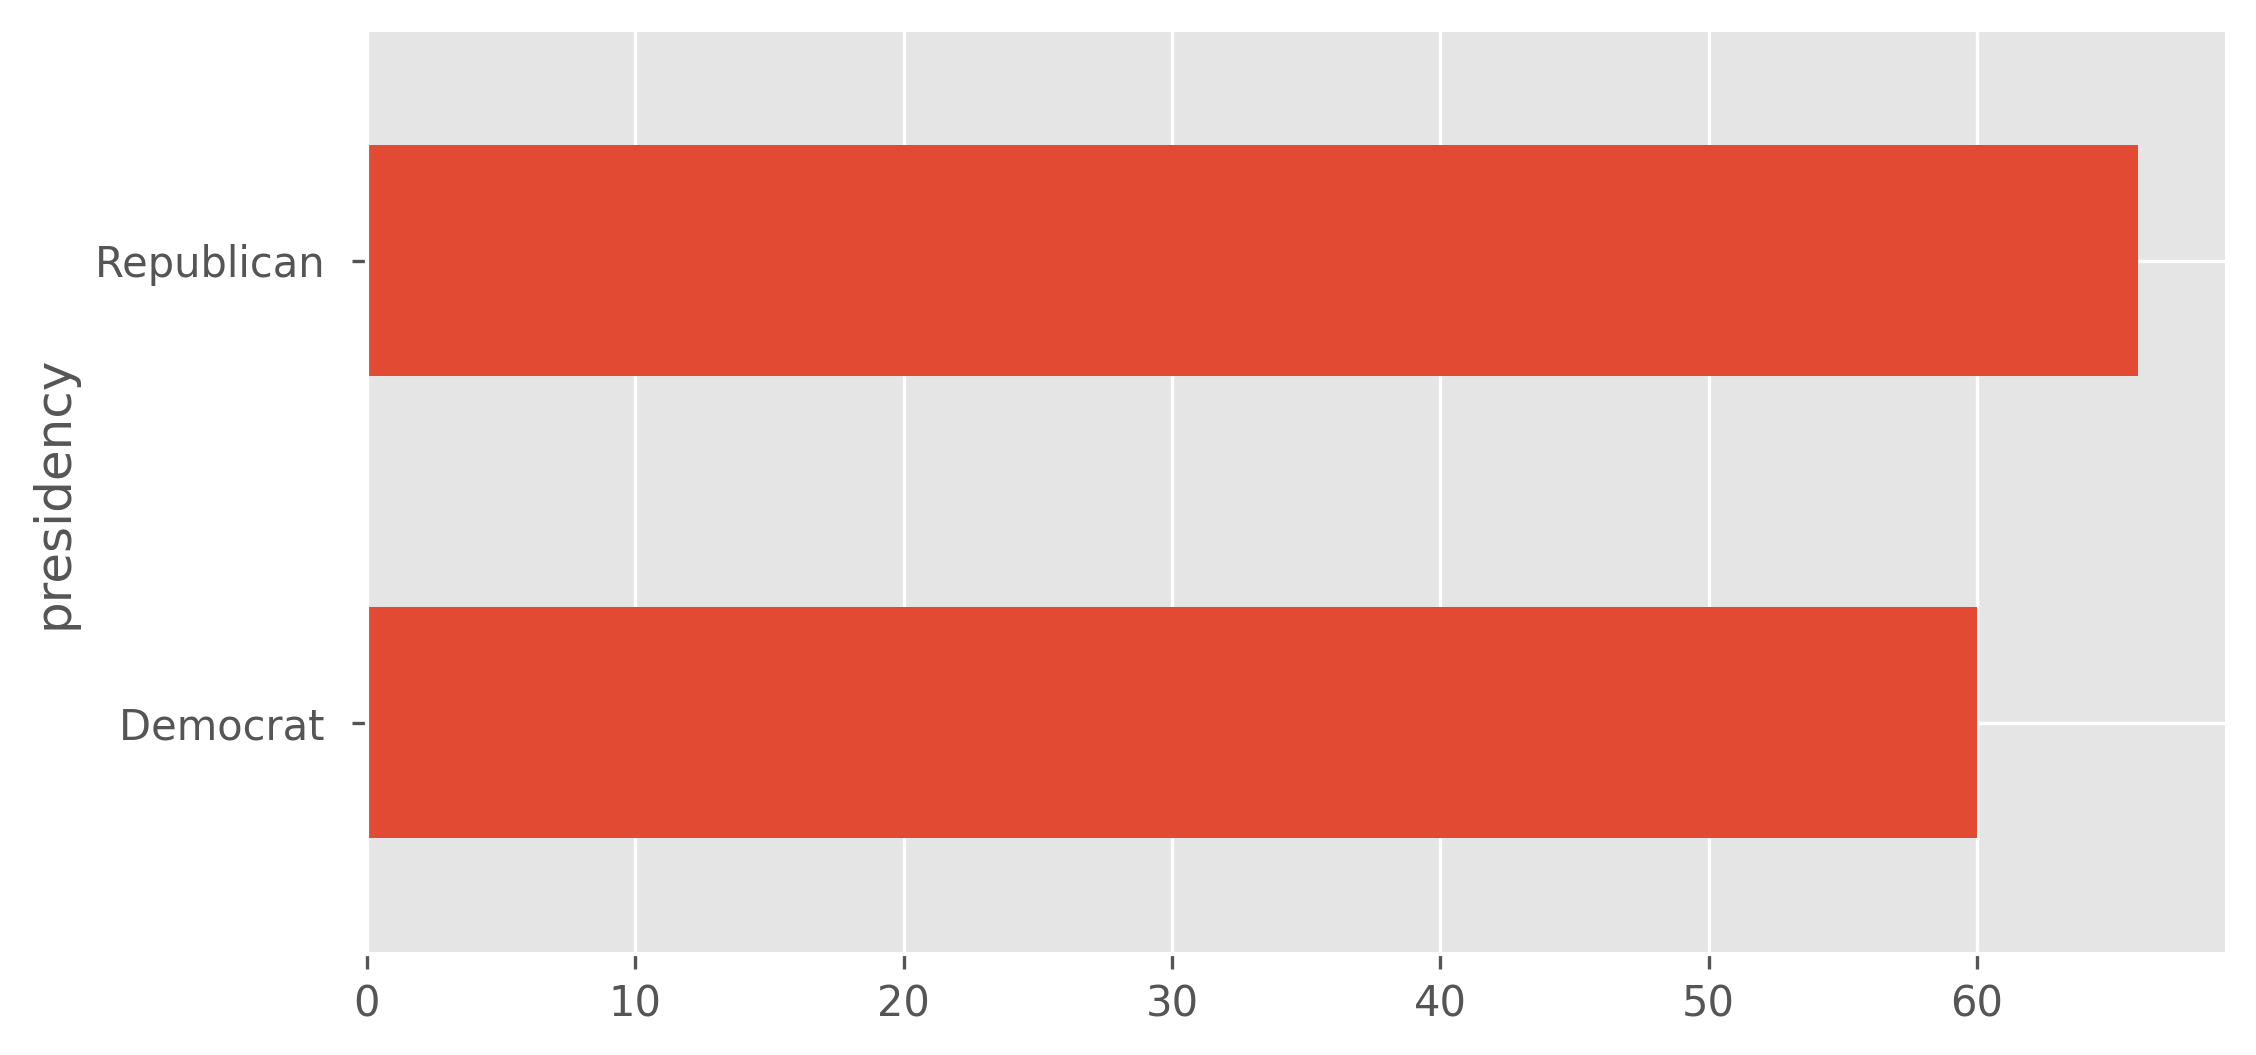

In [ ]:
df["presidency"].value_counts().sort_values(ascending=True).plot.barh();
# how to make it one line
# percentage
# other cols in same graph

In [ ]:
sns.pointplot(x="capacity_ann", y="type", data=df_n);


## Inferential statistics

In [ ]:
sns.pointplot(x="capacity_ann", y="type", data=df_n);


In [ ]:
df_n["capacity_ann"][df_n["status"] != "Planned"].describe()


In [ ]:
_, p, _ = cm.ttest_ind()
confint_low, confint_high = cm.tconfint_diff()
print(f"CI [{confint_low:.2f}, {confint_high:.2f}]")
print(f"p = {p:.3f}")

In [ ]:
st.CompareMeans(
    st.DescrStatsW(df_n["capacity_ann"][df_n["region"] == "Europe"]),
    st.DescrStatsW(df_n["capacity_ann"][df_n["region"] == "North America"]),
).summary()

## Bias and misleading information

if the majority is slim, is this important?

this is one data point in an extremely complicated system. correlation and causantion

## Conclusion